# GleanerIO SHACL processor

## About

Ted Habberman presented to the CDF on ISO metadata analysis.  I have been exploring some approaches to accessing the FAIR Digital Object server that is part of the standard setup supporting GeoCODES and other groups.  Leveraging Python Dask and S3 Boto it is easy to access these object stores in a highly performant manner.  

In addition to DASK there is S3SELECT as well as SPARQL calls on objects and triplestores.  

## Notes

Curious above local context file reading when doing lots of calls.  PyLD seems to know to do caching but not sure how it could in a Dask based pattern.

May need to explore approach to read local files for context like

## Imports


In [1]:
import dask
import pandas as pd
import json
import s3fs
import kglab
from rdflib import Graph  #, plugin

### Setting and options

In [2]:
# Some pandas df options (not needed)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set the shapegraph to use
sg = './shapes/eco_general1.ttl'

# Set up the S3 File system
oss = s3fs.S3FileSystem(
    anon=True,
    client_kwargs = {"endpoint_url":"https://oss.geodex.org"}
)
# [optional] List the directories we can work with later
# oss.ls('gleaner/summoned')


### Definitions

In [3]:
# some color coding for pandas for later
def change_color_group(x):
    dfcg = x.copy()
    dfcg.loc[df['severity'] == "shacl:Violation", :] = 'background-color: #F89782'
    dfcg.loc[df['severity'] == "shacl:Warning", :] = 'background-color: #F0F480'
    dfcg.loc[df['severity'] == "shacl:Info", :] = 'background-color: #CBFBD2'
    return dfcg

In [4]:
# SHACL function
@dask.delayed()
def read_and_validate(fn):
    # make a kg to hold our data graph
    namespaces = {
        "schema":  "https://schema.org/",
        "shacl":   "http://www.w3.org/ns/shacl#" ,
    }

    kg = kglab.KnowledgeGraph(
        name = "Schema.org based datagraph",
        base_uri = "https://example.org/id/",
        namespaces = namespaces,
    )

    with oss.open(fn, 'rb') as f:
        jld = json.loads(f.read().decode("utf-8", "ignore").replace('\n',' '))
        jlds = json.dumps(jld)

        g = Graph().parse(data=jlds, format='json-ld')
        context = {
            "@vocab": "https://schema.org/",
        }

        ttl = g.serialize(format='ttl', context=context, indent=4)
        kg.load_rdf_text(ttl, format="ttl", base=None)

        conforms, report_graph, report_text = kg.validate(
            shacl_graph=sg,
            shacl_graph_format="ttl"
        )

        return report_graph.save_rdf_text()  # return graph object or string of graph

## Get files


In [5]:
from dask.distributed import Client    #, progress
client = Client(threads_per_worker=5, n_workers=4)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 20,Total memory: 31.17 GiB
Comm: tcp://127.0.0.1:37455,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.17 GiB
Comm: tcp://127.0.0.1:42957,Total threads: 5
Dashboard: http://127.0.0.1:34507/status,Memory: 7.79 GiB
Nanny: tcp://127.0.0.1:44629,


In [7]:
%%time

fns = oss.ls('gleaner/summoned/opentopo')
o = [read_and_validate(f) for f in fns]

results = dask.compute(*o)  ## Wait..  can I just dask.compute(o)  ????

CPU times: user 992 ms, sys: 114 ms, total: 1.11 s
Wall time: 6.04 s


### Loop on results and load to graph

In [8]:
rnamespaces = {
    "schema":  "https://schema.org/",
    "shacl":   "http://www.w3.org/ns/shacl#" ,
}

rkg = kglab.KnowledgeGraph(
    name = "Schema.org shacl eval datagraph",
    base_uri = "https://example.org/id/",
    namespaces = rnamespaces,
)

for r in results:
    rkg.load_rdf_text(data=r, format="ttl")

In [9]:
sparql = """
SELECT ?path ?value ?constraint ?severity ?message ?id ?focus
  WHERE {
    ?id rdf:type shacl:ValidationResult .
    ?id shacl:focusNode ?focus .
    ?id shacl:resultMessage ?message .
    ?id shacl:resultSeverity ?severity .
    ?id shacl:sourceConstraintComponent ?constraint .
    OPTIONAL {
        ?id shacl:resultPath ?path .
    }
    OPTIONAL {
        ?id shacl:value ?value .
    }
  }
"""

df = rkg.query_as_df(sparql)

In [10]:
pdf = df.to_pandas()
# pdf.style.apply(change_color_group, axis=None)
pdf.info()
pdf.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        666 non-null    object
 1   constraint  666 non-null    object
 2   severity    666 non-null    object
 3   message     666 non-null    object
 4   id          666 non-null    object
 5   focus       666 non-null    object
dtypes: object(6)
memory usage: 31.3+ KB


,path,constraint,severity,message,id,focus
0,:provider,sh:MinCountConstraintComponent,sh:Violation,A provider must be noted,_:ndf6c8b589c904eafa054c5e8166f9d52b2,<https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.122019.4326.2>
1,:provider,sh:MinCountConstraintComponent,sh:Violation,A provider must be noted,_:n39166e1071d544208e52eae2a12551ddb2,<https://portal.opentopography.org/raster?opentopoID=OTSDEM.052020.6341.1>
2,:provider,sh:MinCountConstraintComponent,sh:Violation,A provider must be noted,_:n8eb081f15bd5496c800c9ea5dd7a3ed5b2,<https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.062019.32736.1>
3,:provider,sh:MinCountConstraintComponent,sh:Violation,A provider must be noted,_:na7c709f17c7547038b30bbc81a802636b2,<https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.032012.26916.1>
4,:provider,sh:MinCountConstraintComponent,sh:Violation,A provider must be noted,_:n10095a9aa7854b1ba287e0ee1418392eb2,<https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.062020.32611.1>
5,:provider,sh:MinCountConstraintComponent,sh:Violation,A provider must be noted,_:nb6a4cb050c924e9487b8cc4a281240f6b2,<https://portal.opentopography.org/raster?opentopoID=OTSDEM.032011.26910.1>
6,:provider,sh:MinCountConstraintComponent,sh:Violation,A provider must be noted,_:n2c0a2e9896d540739d99751c22664591b2,<https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.072018.6635.1>
7,:provider,sh:MinCountConstraintComponent,sh:Violation,A provider must be noted,_:nec94dd2834fa4dc8a780e4056ac910cbb2,<https://portal.opentopography.org/raster?opentopoID=OTSDEM.082016.26913.3>
8,:provider,sh:MinCountConstraintComponent,sh:Violation,A provider must be noted,_:n794a019d7fe6460e87ab321f07fc2df8b2,<https://portal.opentopography.org/raster?opentopoID=OTSDEM.122019.2229.1>
9,:provider,sh:MinCountConstraintComponent,sh:Violation,A provider must be noted,_:n3d63d1c923444f968daf27cf29f25078b2,<https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.032017.26911.1>


In [11]:
pdf["severity"].value_counts()
pdf["focus"].value_counts()
pdf["message"].value_counts()

A provider must be noted    666
Name: message, dtype: int64

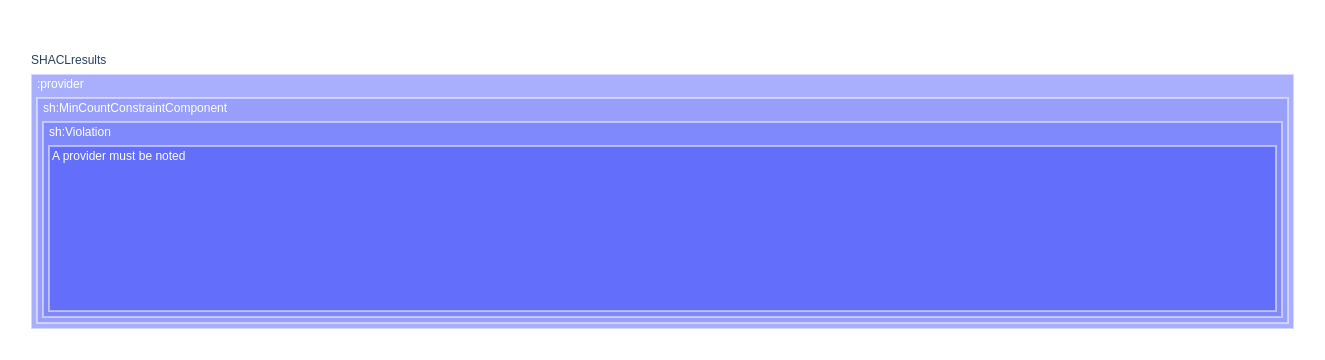

In [15]:
import plotly.express as px

fig = px.treemap(pdf, path=[px.Constant("SHACLresults"), 'path', 'constraint', 'severity', 'message'])
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [13]:
# TODO export to parquet and or CSV
df.to_parquet("./output/eco_opentopo_SHACL.parquet")
df.to_csv("./output/eco_opentopo_SHACL.csv")